## Загрузка необходимых библиотек

In [ ]:
pip install prophet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from concurrent.futures import ProcessPoolExecutor, as_completed


## Загрузка данных

In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
file_path = os.path.join(path, 'household_power_consumption.txt')
df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)
df.head()

100%|██████████| 19.4M/19.4M [00:00<00:00, 66.1MB/s]

Extracting files...



<ipython-input-4-94b5f69c1acd>:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)
<ipython-input-4-94b5f69c1acd>:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Предобработка

In [ ]:
df = df.dropna()
df = df.resample("h", on="Datetime").mean().reset_index()
df = df.interpolate(method="linear")

# Добавляем временные признаки
df["hour"] = df["Datetime"].dt.hour
df["dayofweek"] = df["Datetime"].dt.dayofweek
df["month"] = df["Datetime"].dt.month
df["year"] = df["Datetime"].dt.year
df["day"] = df["Datetime"].dt.day
df["day_of_year"] = df["Datetime"].dt.dayofyear

df = df.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})

df = df.dropna()
df.head()

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,12,2006,16,350
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,12,2006,16,350
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,12,2006,16,350
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,12,2006,16,350
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,12,2006,16,350


In [ ]:
regressors = ['Global_reactive_power', 'Voltage', 'Global_intensity',
              'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
              'hour', 'dayofweek', 'month', 'year', 'day', 'day_of_year']

scaler = StandardScaler()
df[regressors] = scaler.fit_transform(df[regressors])

In [ ]:
test_size = int(len(df) * 0.2)
df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

# Из теста возьмем только последние 48 часов (точек)
df_test_48 = df_test.tail(48)

In [ ]:
df_train.head()

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year
0,2006-12-16 17:00:00,4.222889,1.571567,-2.059519,3.592036,-0.317694,-0.183195,1.420535,0.794378,1.000499,1.624628,-2.15875,0.025727,1.617152
1,2006-12-16 18:00:00,3.632200,-0.651927,-2.080739,2.925296,-0.317694,1.300786,1.421293,0.938838,1.000499,1.624628,-2.15875,0.025727,1.617152
2,2006-12-16 19:00:00,3.400233,-0.574311,-2.529530,2.632820,-0.317694,0.033941,1.396288,1.083299,1.000499,1.624628,-2.15875,0.025727,1.617152
3,2006-12-16 20:00:00,3.268567,-0.725563,-2.250132,2.476358,-0.317694,-0.309746,1.409927,1.227760,1.000499,1.624628,-2.15875,0.025727,1.617152
4,2006-12-16 21:00:00,3.056467,-0.702179,-1.222065,2.244333,-0.317694,-0.209837,1.469029,1.372221,1.000499,1.624628,-2.15875,0.025727,1.617152


## Поиск лучших параметров модели по MSE

In [ ]:
from prophet.diagnostics import performance_metrics
from itertools import product

# Сетка параметров
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1],
    'seasonality_prior_scale': [1.0, 5.0],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

def train_and_evaluate(params):
    try:
        model = Prophet(**params)
        for reg in regressors:
            model.add_regressor(reg)
        model.fit(df_train)
        future = df_test_48[['ds'] + regressors]
        forecast = model.predict(future)
        mse = mean_squared_error(df_test_48['y'].values, forecast['yhat'].values)
        return {'params': params, 'mse': mse}
    except Exception as e:
        return {'params': params, 'mse': np.inf, 'error': str(e)}

results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(train_and_evaluate, p) for p in all_params]
    for future in as_completed(futures):
        results.append(future.result())

results = sorted(results, key=lambda x: x['mse'])
best = results[0]
print("Лучшие параметры:", best['params'])
print(f"MSE: {best['mse']:.4f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbeh0uy9/0ssx2cn0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4kd7q0s0/dg0uulrp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbbeh0uy9/6uz5gsqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4328', 'data', 'file=/tmp/tmpbbeh0uy9/0ssx2cn0.json', 'init=/tmp/tmpbbeh0uy9/6uz5gsqd.json', 'output', 'file=/tmp/tmpbbeh0uy9/prophet_modelhlukvfrl/prophet_model-20250410070351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:03:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4kd7q0s0/c7luxpwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10163', 'data'

Лучшие параметры: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'weekly_seasonality': True, 'daily_seasonality': True}
MSE: 0.0001


## Прогноз и визуализация

DEBUG:cmdstanpy:input tempfile: /tmp/tmptbk3j1y9/w99_9026.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptbk3j1y9/ga_j6i79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69981', 'data', 'file=/tmp/tmptbk3j1y9/w99_9026.json', 'init=/tmp/tmptbk3j1y9/ga_j6i79.json', 'output', 'file=/tmp/tmptbk3j1y9/prophet_model5lkbp6dg/prophet_model-20250410072543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:26:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


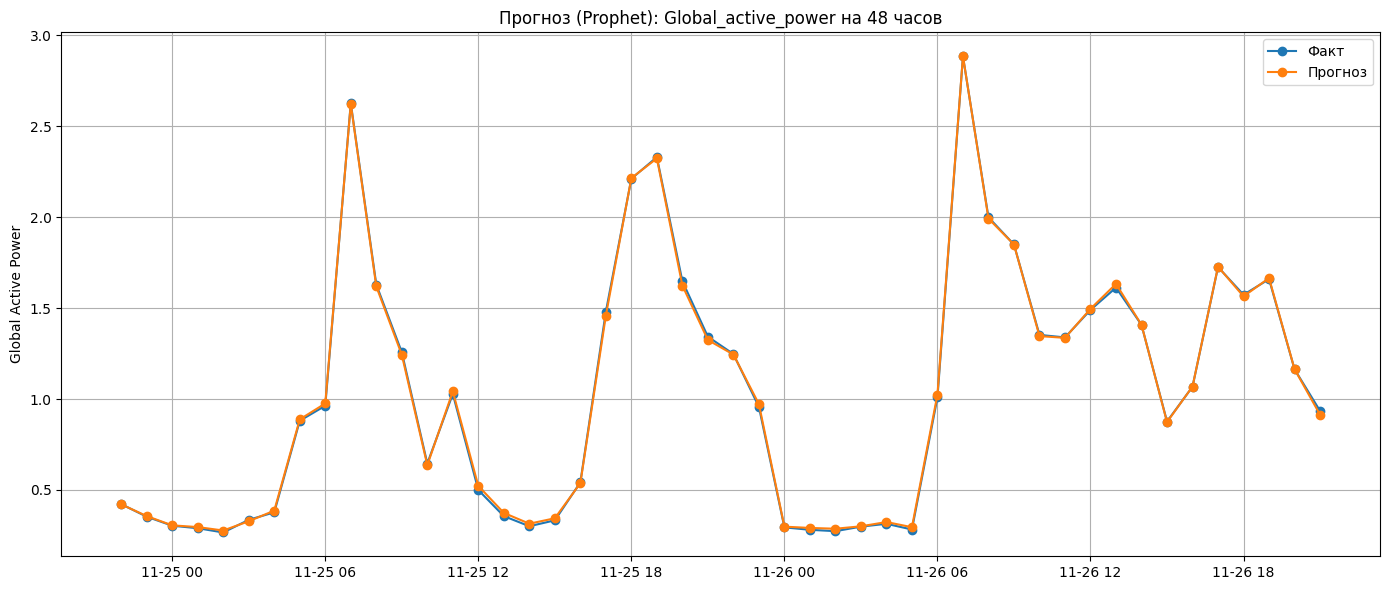

In [ ]:
model = Prophet(**best['params'])
for reg in regressors:
    model.add_regressor(reg)

model.fit(df_train)
forecast = model.predict(df_test_48[['ds'] + regressors])

plt.figure(figsize=(14, 6))
plt.plot(df_test_48['ds'], df_test_48['y'], label='Факт', marker='o')
plt.plot(df_test_48['ds'], forecast['yhat'], label='Прогноз', marker='o')

plt.title('Прогноз (Prophet): Global_active_power на 48 часов')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()